<a href="https://colab.research.google.com/github/hamidanwar/AI-Lab-Tasks/blob/main/AILabAssignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!/usr/bin/env python3
# IDS lab pipeline - run this after uploading data_26.csv.zip to the working folder.
# This version works directly in Colab/Jupyter without command-line arguments.

import os, zipfile, pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings("ignore")

# ------- Configuration -------
ZIP_PATH = "data_26.csv.zip"  # Your uploaded zip file
OUT_DIR = "ids_artifacts"
MAX_ROWS = 200000  # if dataset is huge, sample to speed up training
RANDOM_STATE = 42
# -----------------------------

os.makedirs(OUT_DIR, exist_ok=True)

if not os.path.exists(ZIP_PATH):
    raise FileNotFoundError(f"Zip file not found at {ZIP_PATH}")

# 1) Extract first CSV from zip
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    csvs = [n for n in z.namelist() if n.lower().endswith(".csv")]
    if not csvs:
        raise FileNotFoundError("No CSV found in the provided zip file.")
    csv_name = csvs[0]
    extracted_csv = os.path.join(OUT_DIR, os.path.basename(csv_name))
    with z.open(csv_name) as fin, open(extracted_csv, "wb") as fout:
        fout.write(fin.read())

print("Extracted CSV ->", extracted_csv)

# 2) Load dataframe
df = pd.read_csv(extracted_csv)
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

# 3) Heuristically pick label column
candidate_names = ['label','Label','class','Class','attack','Attack','target','Target','y','Y','intrusion','Intrusion']
label_col = None
for c in candidate_names:
    if c in df.columns:
        label_col = c
        break
if label_col is None:
    # fallback: choose the column with the smallest number of unique values (likely label)
    col_counts = [(col, df[col].nunique(dropna=False)) for col in df.columns]
    col_counts.sort(key=lambda x: x[1])
    label_col = col_counts[0][0]

print("Using label column:", label_col)
print(df[label_col].value_counts(dropna=False).head(20))

# 4) Preprocess X, y
df = df.dropna(how='all').copy()
y_raw = df[label_col].astype(str)
le = LabelEncoder()
y = le.fit_transform(y_raw)
print("Label classes mapping:", dict(enumerate(le.classes_)))

X = df.drop(columns=[label_col]).copy()

# drop constant columns
const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
if const_cols:
    print("Dropping constant columns:", const_cols)
    X.drop(columns=const_cols, inplace=True)

# encode object columns
obj_cols = X.select_dtypes(include=['object','category']).columns.tolist()
for c in obj_cols:
    try:
        X[c] = LabelEncoder().fit_transform(X[c].astype(str))
    except Exception:
        print("Dropping problematic object column:", c)
        X.drop(columns=[c], inplace=True)

# fill NaNs (median for numeric)
X = X.fillna(X.median(numeric_only=True))

print("Features shape after preprocessing:", X.shape)

# if too big, sample for speed (keeps stratified distribution)
if len(X) > MAX_ROWS:
    print(f"Large dataset detected ({len(X)} rows). Sampling {MAX_ROWS} rows for training.")
    rng = np.random.RandomState(RANDOM_STATE)
    idx = rng.choice(len(X), size=MAX_ROWS, replace=False)
    X = X.iloc[idx].reset_index(drop=True)
    y = np.array(y)[idx]

# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=RANDOM_STATE)

# 6) Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 7) Models
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)
mlp = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, early_stopping=True, random_state=RANDOM_STATE)

print("Training RandomForest...")
rf.fit(X_train_s, y_train)
print("Training MLP...")
mlp.fit(X_train_s, y_train)

# 8) Evaluate helper
def evaluate(model, Xs, ys):
    ypred = model.predict(Xs)
    probs = model.predict_proba(Xs) if hasattr(model, "predict_proba") else None
    metrics = {
        "accuracy": accuracy_score(ys, ypred),
        "precision": precision_score(ys, ypred, average='weighted', zero_division=0),
        "recall": recall_score(ys, ypred, average='weighted', zero_division=0),
        "f1": f1_score(ys, ypred, average='weighted', zero_division=0),
        "roc_auc": None
    }
    if probs is not None:
        try:
            if probs.shape[1] == 2:
                metrics["roc_auc"] = roc_auc_score(ys, probs[:,1])
            else:
                metrics["roc_auc"] = roc_auc_score(ys, probs, multi_class='ovo')
        except Exception:
            metrics["roc_auc"] = None
    return metrics, ypred, probs

m_rf, ypred_rf, prob_rf = evaluate(rf, X_test_s, y_test)
m_mlp, ypred_mlp, prob_mlp = evaluate(mlp, X_test_s, y_test)

# 9) Hybrid (average probabilities)
metrics_list = [("RandomForest", m_rf), ("MLP", m_mlp)]
if (prob_rf is not None) and (prob_mlp is not None):
    avg_prob = (prob_rf + prob_mlp) / 2.0
    ypred_hybrid = avg_prob.argmax(axis=1)
    try:
        if avg_prob.shape[1] == 2:
            roc = roc_auc_score(y_test, avg_prob[:,1])
        else:
            roc = roc_auc_score(y_test, avg_prob, multi_class='ovo')
    except Exception:
        roc = None
    m_hybrid = {
        "accuracy": accuracy_score(y_test, ypred_hybrid),
        "precision": precision_score(y_test, ypred_hybrid, average='weighted', zero_division=0),
        "recall": recall_score(y_test, ypred_hybrid, average='weighted', zero_division=0),
        "f1": f1_score(y_test, ypred_hybrid, average='weighted', zero_division=0),
        "roc_auc": roc
    }
    metrics_list.append(("Hybrid(AvgProb)", m_hybrid))
else:
    print("Skipping hybrid: one or both models do not provide probabilities.")

# 10) Save artifacts
pickle.dump(scaler, open(os.path.join(OUT_DIR, "scaler.pkl"), "wb"))
pickle.dump(rf, open(os.path.join(OUT_DIR, "rf_model.pkl"), "wb"))
pickle.dump(mlp, open(os.path.join(OUT_DIR, "mlp_model.pkl"), "wb"))

# 11) Write metrics CSV and show summary
metrics_df = pd.DataFrame({name: vals for name, vals in metrics_list}).T
metrics_df.index.name = "model"
metrics_df.to_csv(os.path.join(OUT_DIR, "metrics_summary.csv"))
print("\nEvaluation metrics (test set):")
print(metrics_df)

# 12) Save classification report and confusion matrices for hybrid if exist
if 'ypred_hybrid' in locals():
    cr = classification_report(y_test, ypred_hybrid, zero_division=0)
    with open(os.path.join(OUT_DIR, "classification_report_hybrid.txt"), "w") as f:
        f.write(cr)
    cm = confusion_matrix(y_test, ypred_hybrid)
    with open(os.path.join(OUT_DIR, "confusion_matrix_hybrid.txt"), "w") as f:
        f.write(str(cm))

print("\nArtifacts saved to folder:", OUT_DIR)
print("Files:", os.listdir(OUT_DIR))
print("\nDone. Submit these files for your assignment:")
print(" - ids_artifacts/* (rf_model.pkl, mlp_model.pkl, scaler.pkl, metrics_summary.csv, ...)")
print(" - a PDF of this script or the IPYNB that ran it")


Extracted CSV -> ids_artifacts/data_26.csv
Data shape: (1000000, 35)
Columns: ['pkSeqID', 'stime', 'flgs', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'smac', 'dmac', 'sum', 'min', 'max', 'soui', 'doui', 'sco', 'dco', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'attack', 'category', 'subcategory ']
Using label column: attack
attack
1    999976
0        24
Name: count, dtype: int64
Label classes mapping: {0: '0', 1: '1'}
Dropping constant columns: ['smac', 'dmac', 'soui', 'doui', 'sco', 'dco']
Features shape after preprocessing: (1000000, 28)
Large dataset detected (1000000 rows). Sampling 200000 rows for training.
Training RandomForest...
Training MLP...

Evaluation metrics (test set):
                 accuracy  precision    recall        f1   roc_auc
model                                                             
RandomForest     1.000000    1.00000  1.000000  1.000000  1.000000
MLP             

In [3]:
from google.colab import files
!zip -r ids_artifacts.zip ids_artifacts
files.download('ids_artifacts.zip')


  adding: ids_artifacts/ (stored 0%)
  adding: ids_artifacts/confusion_matrix_hybrid.txt (deflated 30%)
  adding: ids_artifacts/classification_report_hybrid.txt (deflated 64%)
  adding: ids_artifacts/metrics_summary.csv (deflated 44%)
  adding: ids_artifacts/mlp_model.pkl (deflated 5%)
  adding: ids_artifacts/data_26.csv (deflated 92%)
  adding: ids_artifacts/rf_model.pkl (deflated 89%)
  adding: ids_artifacts/scaler.pkl (deflated 18%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd

# Load metrics CSV from artifacts
metrics_df = pd.read_csv("ids_artifacts/metrics_summary.csv", index_col=0)
metrics_df


,accuracy,precision,recall,f1,roc_auc
model,,,,,
RandomForest,1.000000,1.00000,1.000000,1.000000,1.000000
MLP,0.999975,0.99995,0.999975,0.999963,0.000013
Hybrid(AvgProb),0.999975,0.99995,0.999975,0.999963,1.000000


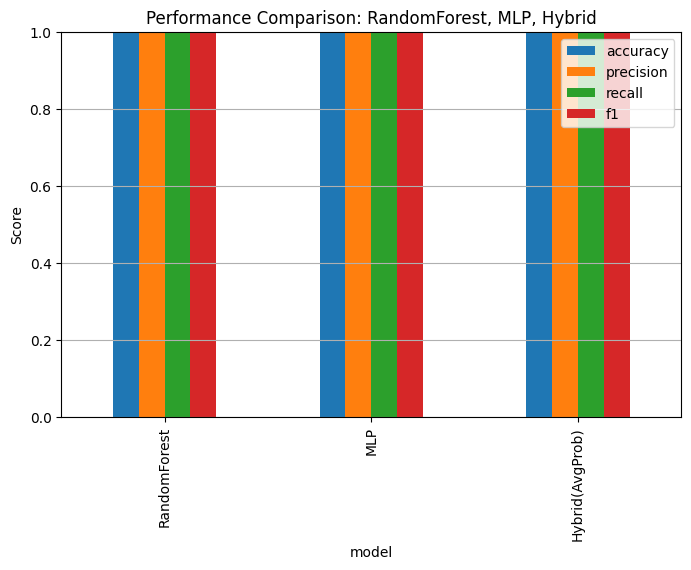

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt

metrics_df[['accuracy','precision','recall','f1']].plot(kind='bar', figsize=(8,5))
plt.title("Performance Comparison: RandomForest, MLP, Hybrid")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()

# Optional: save figure for report
plt.savefig("performance_comparison.png")


In [8]:
import pickle
import pandas as pd
import numpy as np

# Load scaler and models
scaler = pickle.load(open("ids_artifacts/scaler.pkl", "rb"))
rf = pickle.load(open("ids_artifacts/rf_model.pkl", "rb"))
mlp = pickle.load(open("ids_artifacts/mlp_model.pkl", "rb"))

# Load CSV
df = pd.read_csv("ids_artifacts/data_26.csv")  # adjust filename if needed

# Identify label column
candidate_names = ['label','Label','class','Class','attack','Attack','target','Target','y','Y','intrusion','Intrusion']
label_col = None
for c in candidate_names:
    if c in df.columns:
        label_col = c
        break

y_raw = df[label_col].astype(str)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y_raw)

X = df.drop(columns=[label_col]).copy()

# Encode object columns
obj_cols = X.select_dtypes(include=['object','category']).columns.tolist()
for c in obj_cols:
    X[c] = LabelEncoder().fit_transform(X[c].astype(str))

# Drop constant columns (same as original)
const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
X.drop(columns=const_cols, inplace=True)

# Keep only columns used in training
trained_features = scaler.feature_names_in_  # exact columns used in scaler
X = X[trained_features]

# Fill NaNs
X = X.fillna(X.median(numeric_only=True))

# Scale features
X_s = scaler.transform(X)

# Hybrid predictions
prob_rf = rf.predict_proba(X_s)
prob_mlp = mlp.predict_proba(X_s)
avg_prob = (prob_rf + prob_mlp) / 2.0
ypred_hybrid = avg_prob.argmax(axis=1)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, ypred_hybrid)
cm


array([[     0,     24],
       [     0, 999976]])

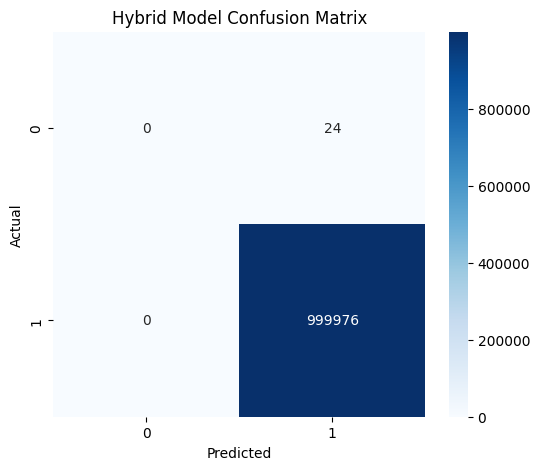

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Hybrid Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.savefig("hybrid_confusion_matrix.png")


In [10]:
import pickle

# Load scaler and trained models
scaler = pickle.load(open("ids_artifacts/scaler.pkl", "rb"))
rf = pickle.load(open("ids_artifacts/rf_model.pkl", "rb"))
mlp = pickle.load(open("ids_artifacts/mlp_model.pkl", "rb"))


In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load your CSV
df = pd.read_csv("ids_artifacts/data_26.csv")

# Identify label column
candidate_names = ['label','Label','class','Class','attack','Attack','target','Target','y','Y','intrusion','Intrusion']
label_col = next((c for c in candidate_names if c in df.columns), None)

# Encode label
y_raw = df[label_col].astype(str)
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Prepare features
X = df.drop(columns=[label_col]).copy()

# Encode object columns
obj_cols = X.select_dtypes(include=['object','category']).columns.tolist()
for c in obj_cols:
    X[c] = LabelEncoder().fit_transform(X[c].astype(str))

# Drop constant columns
const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
X.drop(columns=const_cols, inplace=True)

# Keep same columns as used during training
X = X[scaler.feature_names_in_]

# Fill missing values
X = X.fillna(X.median(numeric_only=True))

# Scale
X_s = scaler.transform(X)


In [12]:
# Get probabilities
prob_rf = rf.predict_proba(X_s)
prob_mlp = mlp.predict_proba(X_s)

# Hybrid: average probabilities
avg_prob = (prob_rf + prob_mlp) / 2.0
ypred_hybrid = avg_prob.argmax(axis=1)


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Metrics
accuracy = accuracy_score(y, ypred_hybrid)
precision = precision_score(y, ypred_hybrid, average='weighted', zero_division=0)
recall = recall_score(y, ypred_hybrid, average='weighted', zero_division=0)
f1 = f1_score(y, ypred_hybrid, average='weighted', zero_division=0)

print("Hybrid Model Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y, ypred_hybrid)
print("\nConfusion Matrix:")
print(cm)

# Classification report
cr = classification_report(y, ypred_hybrid, zero_division=0)
print("\nClassification Report:")
print(cr)


Hybrid Model Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Confusion Matrix:
[[     0     24]
 [     0 999976]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       1.00      1.00      1.00    999976

    accuracy                           1.00   1000000
   macro avg       0.50      0.50      0.50   1000000
weighted avg       1.00      1.00      1.00   1000000



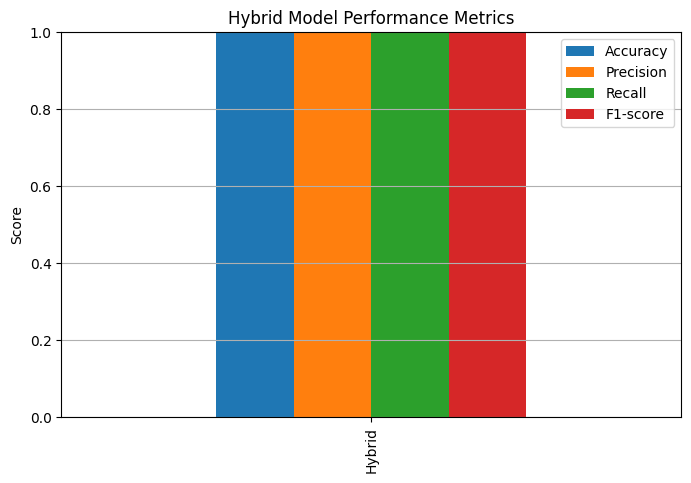

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare metrics for bar plot
metrics_dict = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}

metrics_df = pd.DataFrame(metrics_dict, index=['Hybrid'])

# Plot
metrics_df.plot(kind='bar', figsize=(8,5), legend=True)
plt.title("Hybrid Model Performance Metrics")
plt.ylim(0,1)
plt.ylabel("Score")
plt.grid(axis='y')
plt.show()

# Save figure for report
plt.savefig("hybrid_performance_metrics.png")


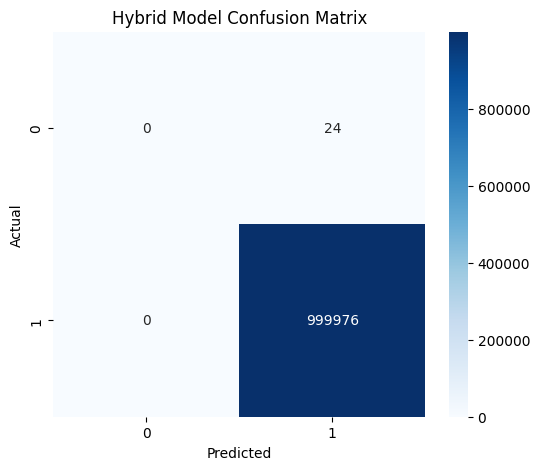

<Figure size 640x480 with 0 Axes>

In [15]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Hybrid Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save figure for report
plt.savefig("hybrid_confusion_matrix.png")
